In [1]:
import numpy as np
import sys

sys.path.append("../src/")  # append path to where Amoeba is installed if elsewhere
from amoeba.Classes.blr import BroadLineRegion
from amoeba.Classes.blr_streamline import Streamline
import amoeba.Util.util as util

from astropy.io import fits
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
from skimage.transform import rescale
import astropy.nddata
import glob
import time

### Current issue: BLR projection is not producing the correct sized output. There is a pixel scaling issue to be addressed. (See projection plots at end)

## The BLR streamline

The BLR in Amoeba is defined in the R-Z plane assuming cylindrical symmetry. The (0, 0) point represents the SMBH. The radial extent of the BLR is flexible and depends on the streamlines used. We use the model for streamlines as outlined in Yong+17, which define accelerating streams of material. These have parameters:

launch_radius, the radius of the initial point of the streamline in gravitational radii.

launch_theta, the angle with respect to the norm of the accretion disk in degrees (0 is launched normal to the accretion disk, 90 is launched tangential to the accretion disk).

max_height, the vertical extent to calculate the BLR out to in gravitational radii.

characteristic_distance, the characteristic distance which defines the acceleration of the streamline in gravitational radii.

asymptotic_poloidal_velocity, the asymptotic velocity in the outflowing direction in units v/c.

height_step, the spacing between different slabs of material in the BLR in gravitational radii. Note that highly resolving the BLR will greatly increase the computational workload!

launch_height, the height of the initial point of the streamline in gravitational radii. Note that this should be greater than 0.

poloidal_launch_velocity, the intial velocity which material is launched. 

alpha_acceleration_value, the exponent of the acceleration.

(velocity_vector, radial_vector), an alternative method of defining other streamlines. These vectors represent the v_poloidal and r values at each height, defined by max_height and height_step parameters. This is experimental, but can allow for bending streamlines, alternative velocity gradients, etc.

## The BLR

The BLR has some additional information defined by the paramters:

smbh_mass_exp, the log of the supermassive black hole's mass normalized by the solar mass. log_10(M/M_sun)

rest_frame_wavelength_in_nm, the rest frame wavelength which the line is emitting at

redshift_source, the redshift of the AGN.

radial_step, the radial resolution in gravitational radii.

max_radius, the maximum radius of the BLR object. Note that this increases if a streamline with greater radius is added.

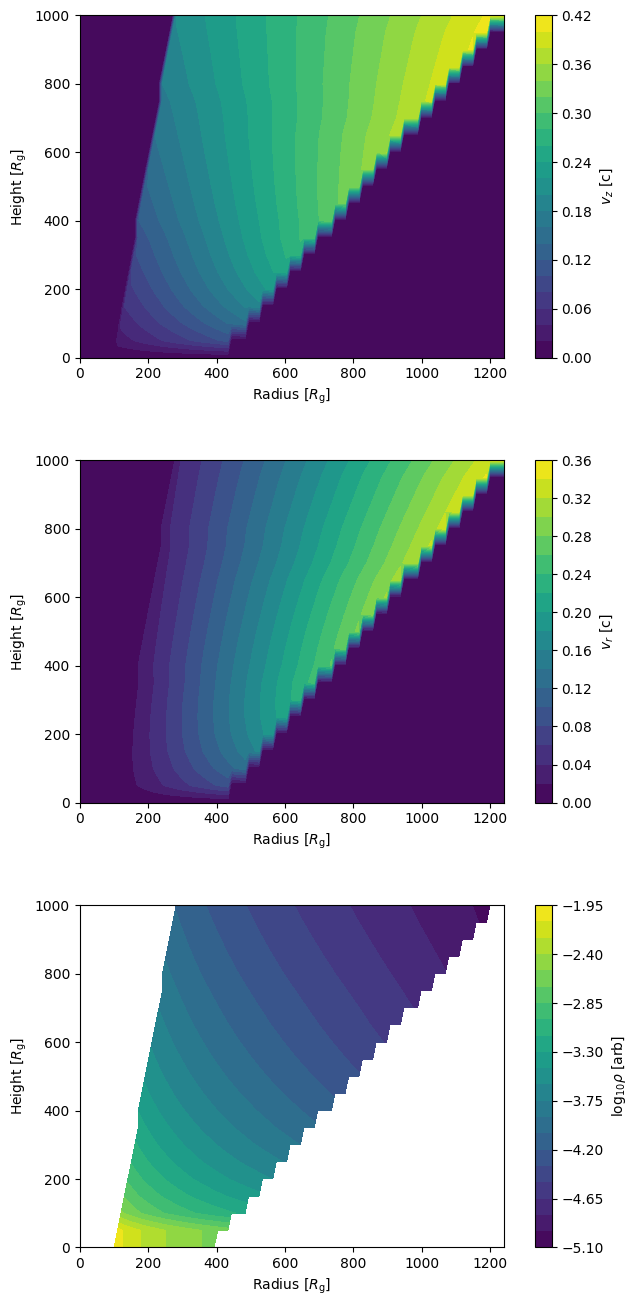

In [2]:
t_start = time.time()

max_height = 1000  # R_g
smbh_mass_exp = 8.0
wavelength = 400  # nm
redshift_source = 2.0
sl_1_rlaunch = 100  # R_g
sl_2_rlaunch = 400
sl_1_theta = 10  # deg
sl_2_theta = 40
sl_1_char_dist = 1000  # R_g
sl_2_char_dist = 400
sl_1_asy_vel = 0.4  # v/c
sl_2_asy_vel = 0.7

testingBLR = BroadLineRegion(
    smbh_mass_exp, max_height, wavelength, redshift_source, radial_step=10, height_step=50
)


SL1 = Streamline(sl_1_rlaunch, sl_1_theta, max_height, sl_1_char_dist, sl_1_asy_vel, height_step=50)
SL2 = Streamline(sl_2_rlaunch, sl_2_theta, max_height, sl_2_char_dist, sl_2_asy_vel, height_step=50)

testingBLR.add_streamline_bounded_region(SL1, SL2)
R, Z = np.meshgrid(testingBLR.radii_values, testingBLR.height_values)

fig, ax = plt.subplots(3, figsize=(8, 16))
conts = ax[0].contourf(R, Z, (testingBLR.z_velocity_grid.T), 20)
ax[1].set_xlabel(r"Radius [$R_{\rm g}$]")
ax[0].set_ylabel(r"Height [$R_{\rm g}$]")
ax[1].set_ylabel(r"Height [$R_{\rm g}$]")
ax[2].set_ylabel(r"Height [$R_{\rm g}$]")
cbar = plt.colorbar(conts, ax=ax[0], label=r"$v_{z}$ [c]")

conts2 = ax[1].contourf(R, Z, (testingBLR.r_velocity_grid.T), 20)
ax[2].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar2 = plt.colorbar(conts2, ax=ax[1], label=r"$v_{r}$ [c]")


conts3 = ax[2].contourf(R, Z, np.log10(testingBLR.density_grid.T), 20)
ax[0].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar3 = plt.colorbar(conts3, ax=ax[2], label=r"log$_{10} \rho$ [arb]")
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[2].set_aspect(1)
plt.subplots_adjust(hspace=0.3)
# fig.savefig("BLRGeometry.pdf")
plt.show()

We have three plots here, representing the z-component of the velocity, the r-component of the velocity, and the density at each voxel.

This can be projected in multiple ways, first start with the particle density.

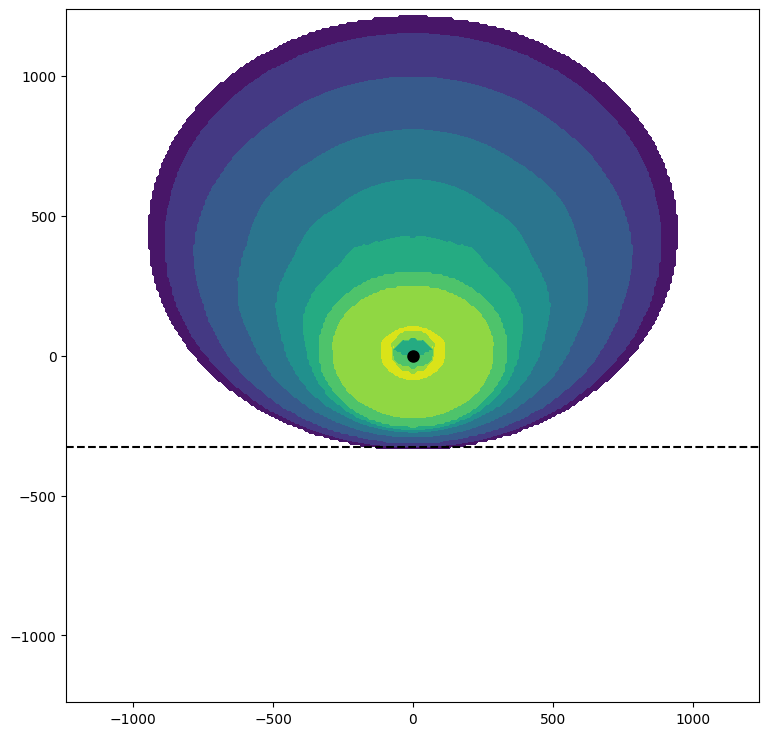

In [3]:
inc_ang = 35
projection = testingBLR.project_blr_density_to_source_plane(inc_ang)
inc_ang *= np.pi / 180
# x_vals, y_vals = projection.get_plotting_axes()

x_vals = np.linspace(
    -testingBLR.max_radius, testingBLR.max_radius, np.size(projection, 0)
)
X, Y = np.meshgrid(x_vals, x_vals)

baseline = (sl_2_rlaunch) * np.cos(inc_ang)

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot([0], [0], "k.", markersize=16)
ax.plot([x_vals[0], x_vals[-1]], [-baseline, -baseline], "k--", markersize=1)
# Once inc_ang > SL2_theta, BLR should be above this line!
ax.contourf(X, Y, np.log10(projection))
ax.set_aspect(1)
plt.show()

This can be rescaled to increase resolution via interpolation, however the greatest density is at the base since the acceleration causes a reduction in density

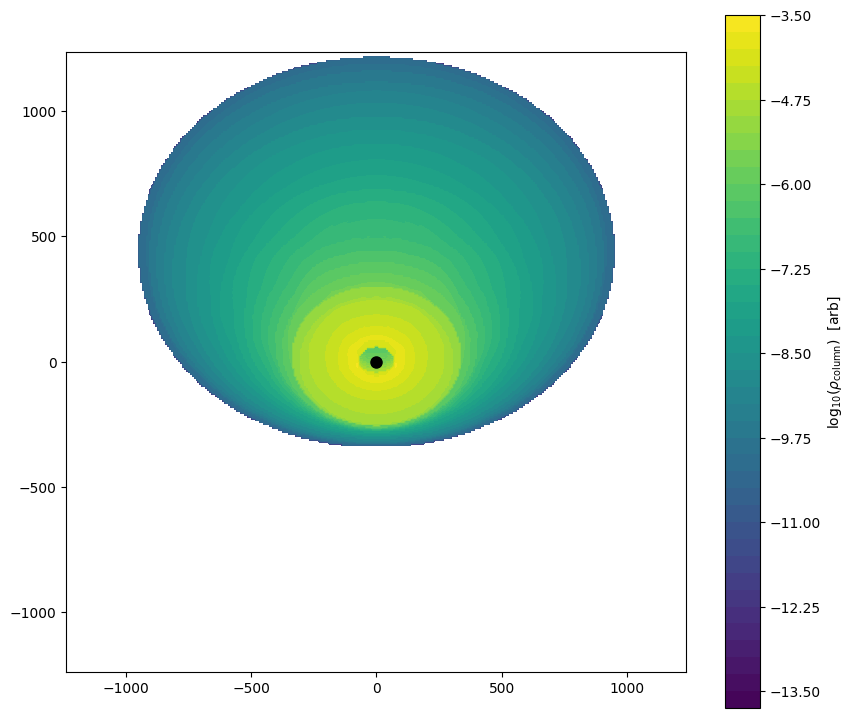

In [4]:
rescaled_projection = rescale(projection, 30)
x_vals = np.linspace(
    -testingBLR.max_radius, testingBLR.max_radius, np.size(rescaled_projection, 0)
)
y_vals = np.linspace(
    -testingBLR.max_radius, testingBLR.max_radius, np.size(rescaled_projection, 1)
)
fig, ax = plt.subplots(figsize=(10, 9))
ax.plot([0], [0], "k.", markersize=16)
# ax.plot([-testingBLR.max_r,testingBLR.max_r], [-baseline,-baseline], 'k--', markersize=1)
contours = ax.contourf(x_vals, y_vals, np.log10(rescaled_projection), 40)
cbar = plt.colorbar(contours, ax=ax, label=r"log$_{10} (\rho_{\rm{column}})$  [arb]")
ax.set_aspect(1)
# fig.savefig("BLRColumnDensity.pdf")
plt.show()

We can compute the scattering transfer function, which assumes the response is only proportional to the particle density. Note that this is not the traditional BLR reverberation, which is described afterwards for particular emission lines.

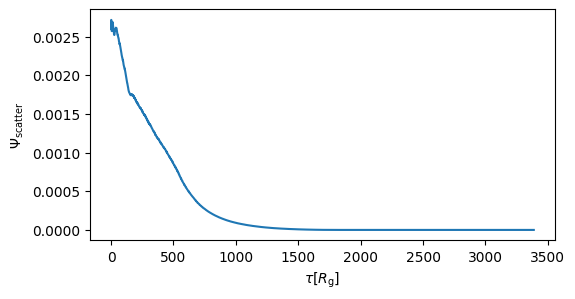

In [5]:
inc_ang = 45

scattering_tf = testingBLR.calculate_blr_scattering_transfer_function(inc_ang)

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(scattering_tf)

ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi_{\rm{scatter}}$")


plt.show()

Emission lines impact only the filters which they fall within. Amoeba computes this impact by determining the velocity range required to shift an emission line into the observer's filter, then masking out portions of the BLR which would not contribute. To see this, we can define a velocity range which highlights the receeding BLR.

In [6]:
velocity_range = [-1, 0]  # units c, negative is away from observer
inc_ang = 45  # deg

rescale_projection = testingBLR.project_blr_density_to_source_plane(inc_ang)
rescale_vel_slice = testingBLR.project_blr_intensity_over_velocity_range(
    inc_ang, velocity_range=velocity_range
).flux_array

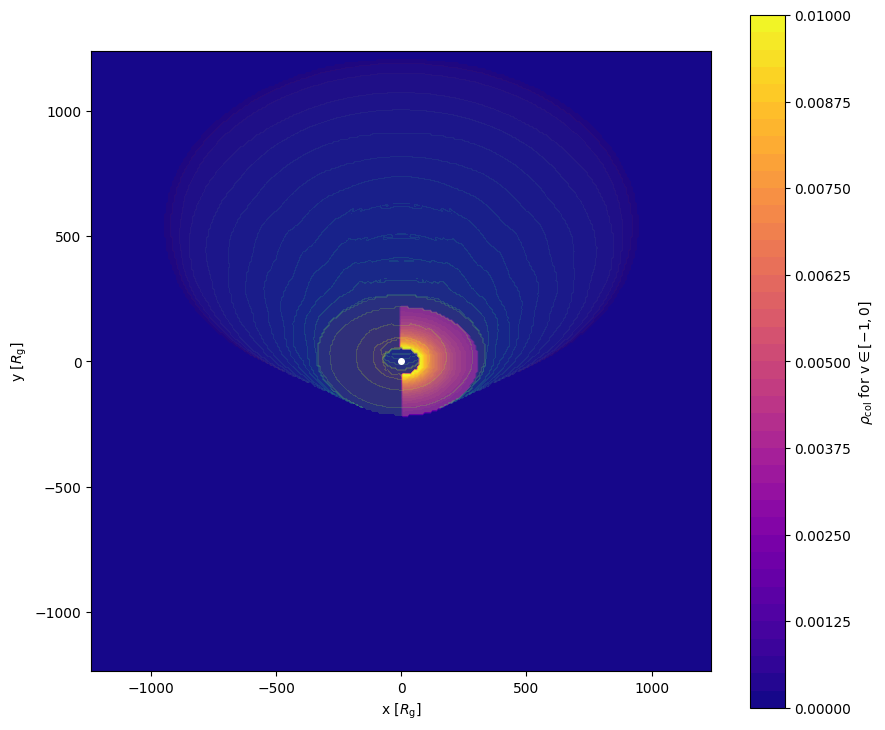

In [7]:
cur_x = np.linspace(-np.max(x_vals), np.max(x_vals), np.size(rescale_vel_slice, 0))
X, Y = np.meshgrid(cur_x, cur_x)


xalign1 = -0.8 * np.max(x_vals)
xalign2 = 0
yalign = -0.5 * np.max(y_vals)
deltay = 0.1 * np.max(y_vals)

fig, ax = plt.subplots(figsize=(10, 9))
contours = ax.contourf(X, Y, rescale_vel_slice, 40, cmap="plasma")
ax.contourf(X, Y, np.log10(rescale_projection), 20, alpha=0.2)
cbar = plt.colorbar(
    contours,
    ax=ax,
    label=r"$\rho_{\rm{col}} \rm{~for~} v \in ["
    + str(velocity_range[0])
    + ", "
    + str(velocity_range[1])
    + "] $",
)
ax.plot([0], [0], "w.-", markersize=8)
ax.set_xlabel(r"x [$R_{\rm{g}}$]")
ax.set_ylabel(r"y [$R_{\rm{g}}$]")

ax.set_aspect(1)
# fig.savefig("ReceedingVelSliceEO.pdf")
plt.show()

## Transfer functions within a specified wavelength range

In [8]:
observed_wavelength_range_in_nm = [1000, 1200]

strength, v_selected_TF = testingBLR.calculate_blr_emission_line_transfer_function(
    inc_ang, observed_wavelength_range_in_nm=observed_wavelength_range_in_nm
)

Recall that by default, testingBLR has a natural emitted wavelength of 400 nm and is located at redshift 2. Therefore, the default range of  will probe an approaching section of the emission line.

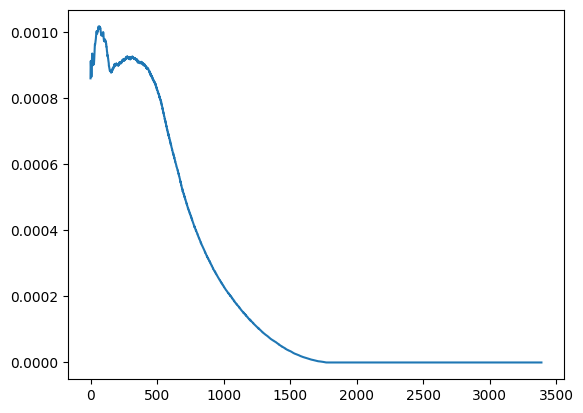

In [9]:
fig, ax = plt.subplots()
ax.plot(v_selected_TF * strength)
plt.show()

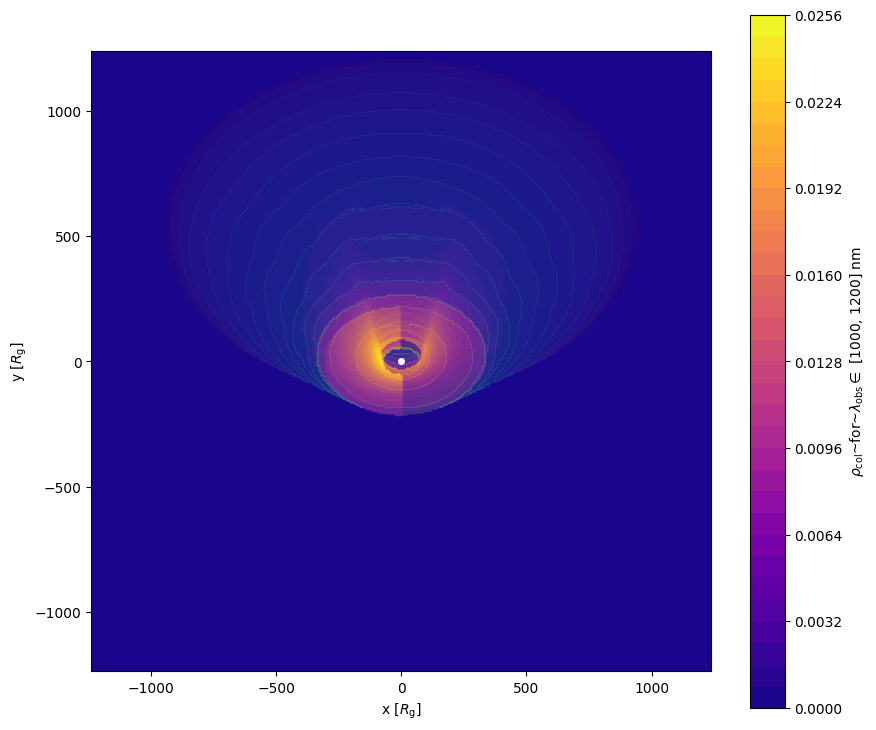

In [10]:
xalign1 = -0.8 * np.max(x_vals)
xalign2 = 0
yalign = -0.5 * np.max(y_vals)
deltay = 0.1 * np.max(y_vals)

v_slice = testingBLR.project_blr_intensity_over_velocity_range(
    inc_ang, observed_wavelength_range_in_nm=observed_wavelength_range_in_nm
).flux_array

fig, ax = plt.subplots(figsize=(10, 9))
contours = ax.contourf(X, Y, v_slice, 40, cmap="plasma")
ax.contourf(X, Y, np.log10(rescale_projection), 20, alpha=0.2)
cbar = plt.colorbar(
    contours,
    ax=ax,
    label=r"$\rho_{\rm{col}} $~for~$ \lambda_{\rm{obs}} \in$ ["
    + str(observed_wavelength_range_in_nm[0])
    + ", "
    + str(observed_wavelength_range_in_nm[1])
    + "] nm",
)
ax.plot([0], [0], "w.-", markersize=8)
ax.set_xlabel(r"x [$R_{\rm{g}}$]")
ax.set_ylabel(r"y [$R_{\rm{g}}$]")

ax.set_aspect(1)

plt.show()

The approaching side of the BLR is highlighted, while some contribution comes from accelerated regions on the receeding side (where v_z is greater than v_phi)

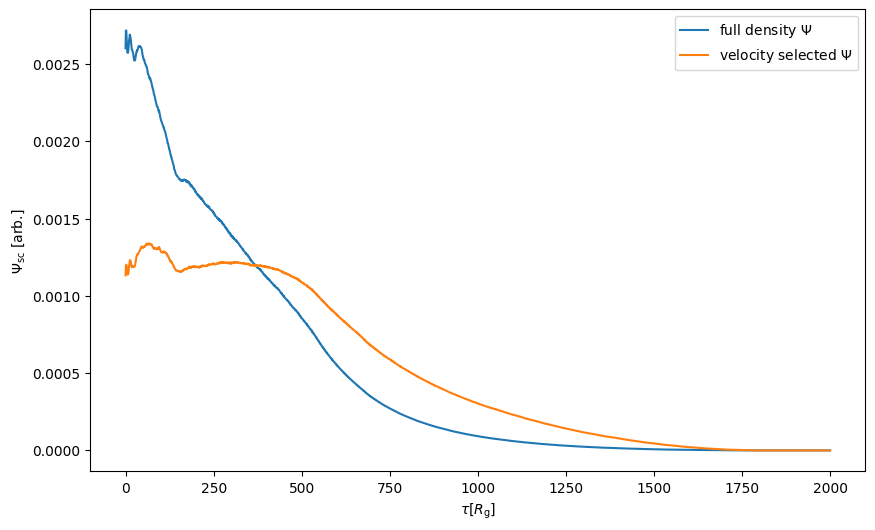

In [11]:
lim = 2000

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scattering_tf[:lim], label=r"full density $\Psi$")
ax.plot(v_selected_TF[:lim], label=r"velocity selected $\Psi$")

ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi_{\rm{sc}}$ [arb.]")
ax.legend()

plt.show()

Adding another region bounded by streamlines will overwrite anything it overlaps, but they are appended to the existing r,z grids. First we will extend a grid with a second region that touches the first.

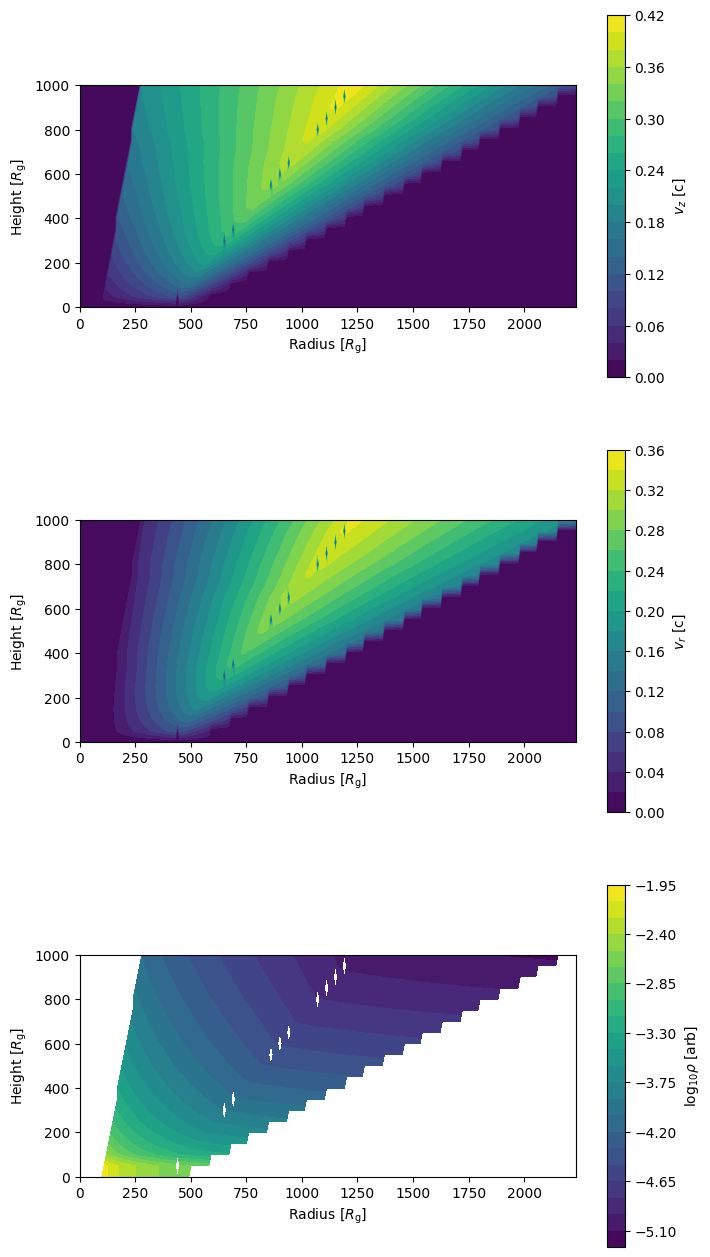

In [12]:
zmax = 1000  # R_g
mexp = 8.0

sl_3_rlaunch = 500
sl_3_theta = 60
sl_3_char_dist = 1000
sl_3_asy_vel = 0.3

testingBLR = BroadLineRegion(
    smbh_mass_exp, max_height, wavelength, redshift_source, radial_step=10, height_step=50
)

SL1 = Streamline(sl_1_rlaunch, sl_1_theta, zmax, sl_1_char_dist, sl_1_asy_vel, height_step=50)
SL2 = Streamline(sl_2_rlaunch, sl_2_theta, zmax, sl_2_char_dist, sl_2_asy_vel, height_step=50)
SL3 = Streamline(sl_3_rlaunch, sl_3_theta, zmax, sl_3_char_dist, sl_3_asy_vel, height_step=50)

testingBLR.add_streamline_bounded_region(SL1, SL2)
testingBLR.add_streamline_bounded_region(SL2, SL3)

R, Z = np.meshgrid(testingBLR.radii_values, testingBLR.height_values)

fig, ax = plt.subplots(3, figsize=(8, 16))
conts = ax[0].contourf(R, Z, (testingBLR.z_velocity_grid.T), 20)
ax[1].set_xlabel(r"Radius [$R_{\rm g}$]")
ax[0].set_ylabel(r"Height [$R_{\rm g}$]")
ax[1].set_ylabel(r"Height [$R_{\rm g}$]")
ax[2].set_ylabel(r"Height [$R_{\rm g}$]")
cbar = plt.colorbar(conts, ax=ax[0], label=r"$v_{z}$ [c]")

conts2 = ax[1].contourf(R, Z, (testingBLR.r_velocity_grid.T), 20)
ax[2].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar2 = plt.colorbar(conts2, ax=ax[1], label=r"$v_{r}$ [c]")


conts3 = ax[2].contourf(R, Z, np.log10(testingBLR.density_grid.T), 20)
ax[0].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar3 = plt.colorbar(conts3, ax=ax[2], label=r"log$_{10} \rho$ [arb]")
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[2].set_aspect(1)
plt.show()

There are some pixels which are not defined due to the interpolation, but this is not a big problem.

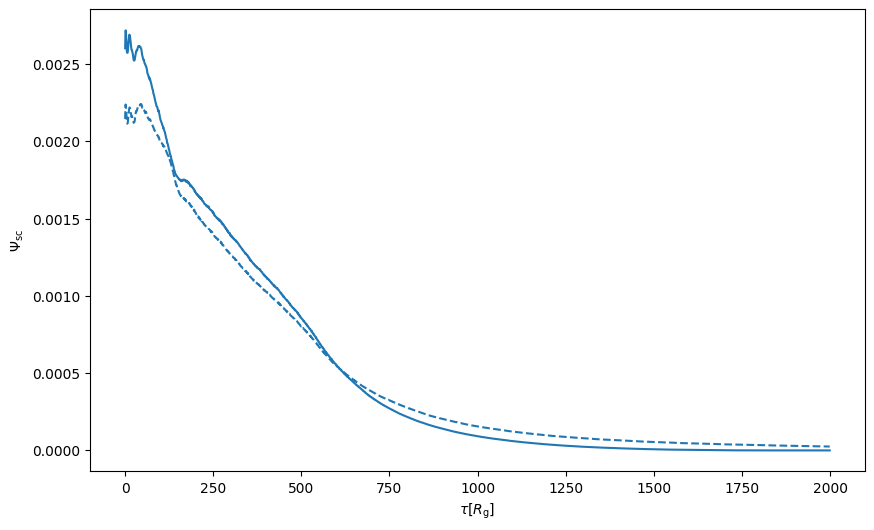

In [13]:
scattering_tf_extra_section = testingBLR.calculate_blr_scattering_transfer_function(
    inc_ang
)

lim = 2000

# plot original and new transfer functions
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scattering_tf[:lim])

plt.gca().set_prop_cycle(
    None
)  # reset color cycle, especially nice for multiple inclinations
ax.plot(scattering_tf_extra_section[:lim], "--")  # add new TFs to plot as dashed lines


ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi_{\rm{sc}}$")

plt.show()

If we instead use the boundaries of SL1 and SL3 and only assume there is one large region, we get the following...

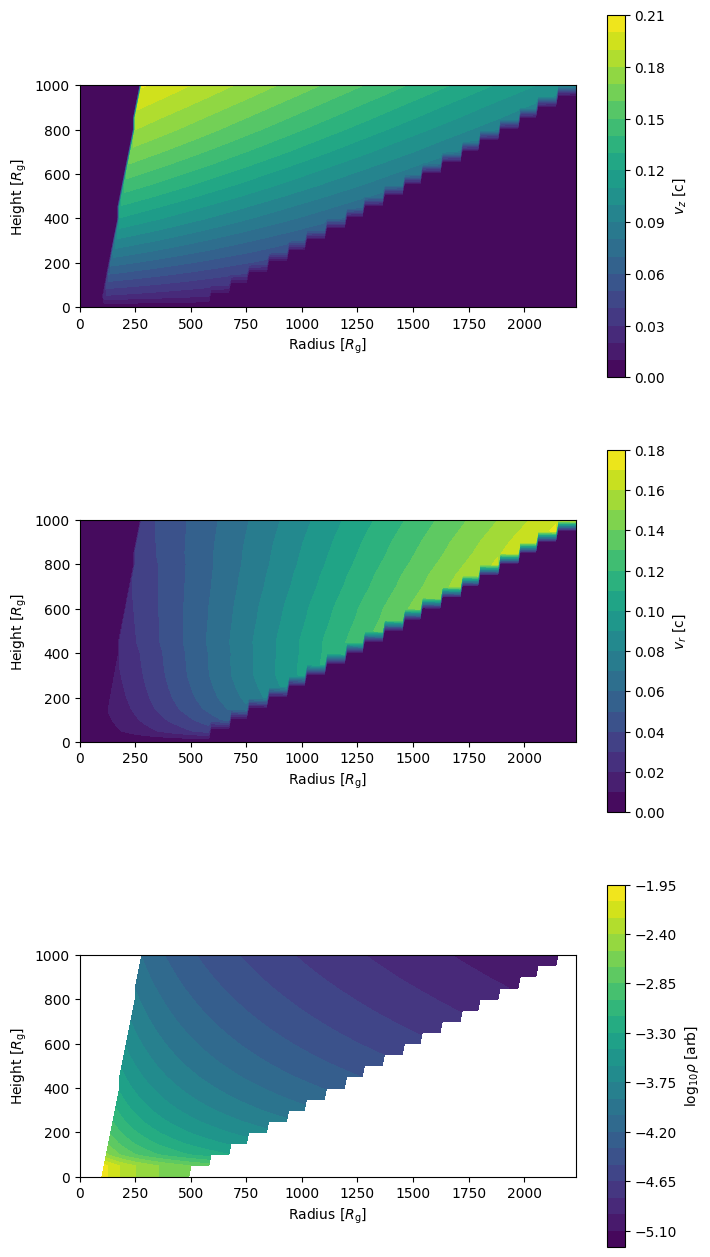

In [14]:
alt_BLR = BroadLineRegion(
    smbh_mass_exp, max_height, wavelength, redshift_source, radial_step=10, height_step=50
)
alt_BLR.add_streamline_bounded_region(SL1, SL3)

R, Z = np.meshgrid(alt_BLR.radii_values, alt_BLR.height_values)

fig, ax = plt.subplots(3, figsize=(8, 16))
conts = ax[0].contourf(R, Z, (alt_BLR.z_velocity_grid.T), 20)
ax[1].set_xlabel(r"Radius [$R_{\rm g}$]")
ax[0].set_ylabel(r"Height [$R_{\rm g}$]")
ax[1].set_ylabel(r"Height [$R_{\rm g}$]")
ax[2].set_ylabel(r"Height [$R_{\rm g}$]")
cbar = plt.colorbar(conts, ax=ax[0], label=r"$v_{z}$ [c]")

conts2 = ax[1].contourf(R, Z, (alt_BLR.r_velocity_grid.T), 20)
ax[2].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar2 = plt.colorbar(conts2, ax=ax[1], label=r"$v_{r}$ [c]")


conts3 = ax[2].contourf(R, Z, np.log10(alt_BLR.density_grid.T), 20)
ax[0].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar3 = plt.colorbar(conts3, ax=ax[2], label=r"log$_{10} \rho$ [arb]")
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[2].set_aspect(1)
plt.show()

In [15]:
scattering_TF_alt = alt_BLR.calculate_blr_scattering_transfer_function(inc_ang)

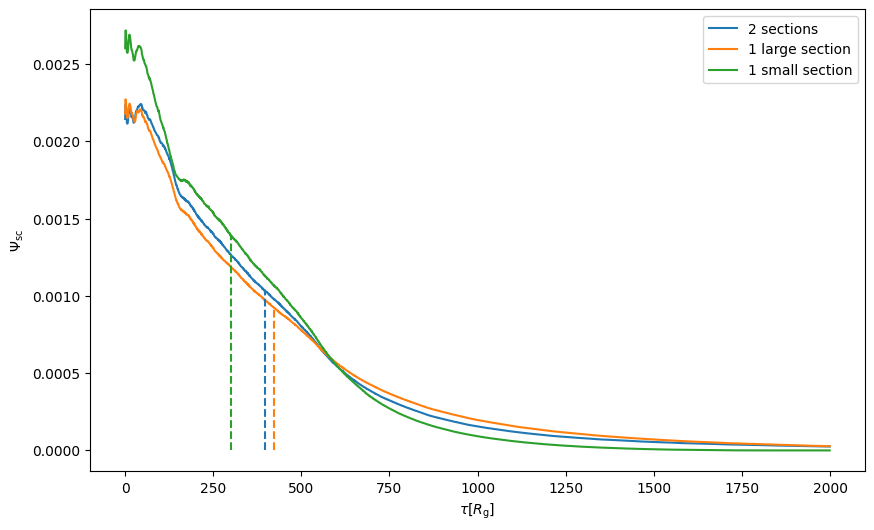

In [16]:
lim = 2000

tau_ax = np.linspace(
    0, len(scattering_tf_extra_section), len(scattering_tf_extra_section)
)
mean_extra_section = np.sum(scattering_tf_extra_section * tau_ax) / np.sum(
    scattering_tf_extra_section
)

tau_ax = np.linspace(0, len(scattering_TF_alt), len(scattering_TF_alt))
mean_alt = np.sum(scattering_TF_alt * tau_ax) / np.sum(scattering_TF_alt)

tau_ax = np.linspace(0, len(scattering_tf), len(scattering_tf))
mean_original = np.sum(scattering_tf * tau_ax) / np.sum(scattering_tf)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scattering_tf_extra_section[:lim], label="2 sections")
ax.plot(scattering_TF_alt[:lim], label="1 large section")
ax.plot(scattering_tf[:lim], label="1 small section")

ax.set_prop_cycle(None)
ax.plot(
    [mean_extra_section, mean_extra_section],
    [0, scattering_tf_extra_section[int(mean_extra_section)]],
    "--",
)
ax.plot([mean_alt, mean_alt], [0, scattering_TF_alt[int(mean_alt)]], "--")
ax.plot([mean_original, mean_original], [0, scattering_tf[int(mean_original)]], "--")

ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi_{\rm{sc}}$")
ax.legend()

plt.show()

Now making a more complex BLR geometry...

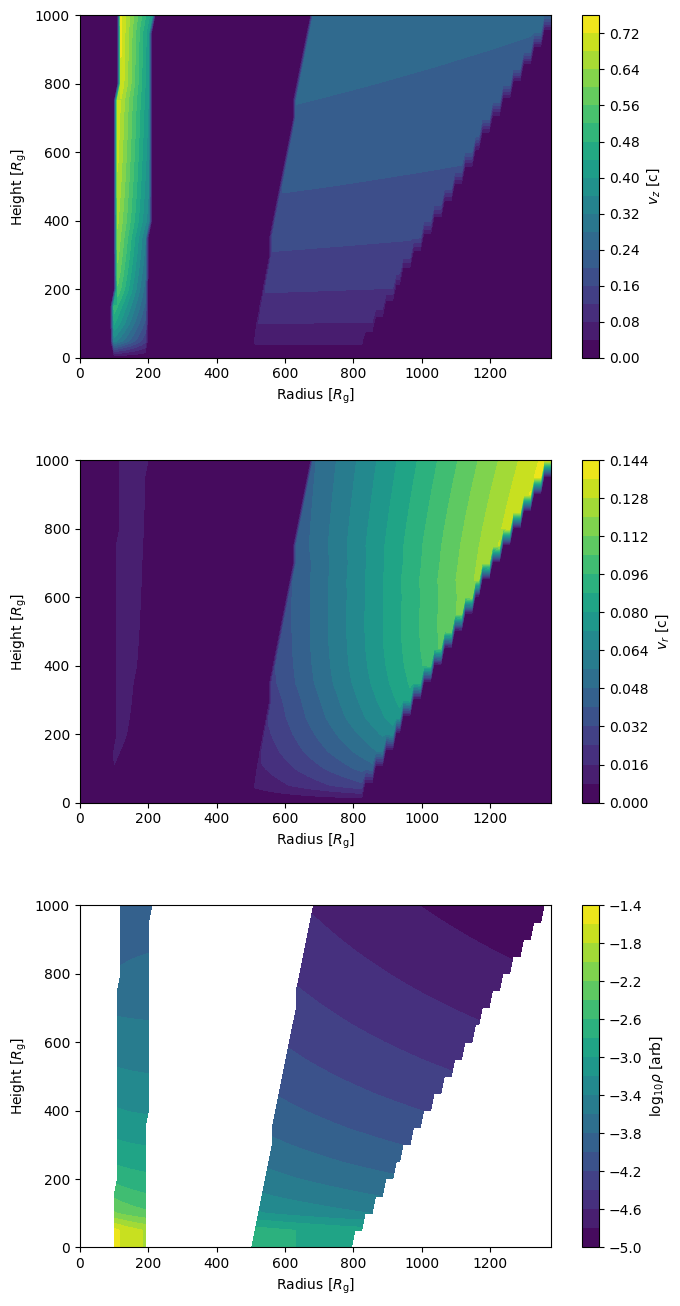

In [17]:
zmax = 1000  # R_g
mexp = 8.0
sl1_rlaunch = 100  # R_g
sl2_rlaunch = 200
sl1_theta = 1  # deg
sl2_theta = 1
sl1_char_dist = 100  # R_g
sl2_char_dist = 200
sl1_asy_vel = 0.8  # v/c
sl2_asy_vel = 0.5

sl3_rlaunch = 500  # R_g
sl4_rlaunch = 800
sl3_theta = 10  # deg
sl4_theta = 30
sl3_char_dist = 500  # R_g
sl4_char_dist = 500
sl3_asy_vel = 0.4  # v/c
sl4_asy_vel = 0.4


comp_BLR = BroadLineRegion(mexp, zmax, wavelength, redshift_source, radial_step=10, height_step=50)

SL1 = Streamline(sl1_rlaunch, sl1_theta, zmax, sl1_char_dist, sl1_asy_vel, height_step=50)
SL2 = Streamline(sl2_rlaunch, sl2_theta, zmax, sl2_char_dist, sl2_asy_vel, height_step=50)
SL3 = Streamline(sl3_rlaunch, sl3_theta, zmax, sl3_char_dist, sl3_asy_vel, height_step=50)
SL4 = Streamline(sl4_rlaunch, sl4_theta, zmax, sl4_char_dist, sl4_asy_vel, height_step=50)

comp_BLR.add_streamline_bounded_region(SL1, SL2, density_initial_weighting=3)

comp_BLR.add_streamline_bounded_region(SL3, SL4, density_initial_weighting=1)

R, Z = np.meshgrid(comp_BLR.radii_values, comp_BLR.height_values)

fig, ax = plt.subplots(3, figsize=(8, 16))
conts = ax[0].contourf(R, Z, (comp_BLR.z_velocity_grid.T), 20)
ax[1].set_xlabel(r"Radius [$R_{\rm g}$]")
ax[0].set_ylabel(r"Height [$R_{\rm g}$]")
ax[1].set_ylabel(r"Height [$R_{\rm g}$]")
ax[2].set_ylabel(r"Height [$R_{\rm g}$]")
cbar = plt.colorbar(conts, ax=ax[0], label=r"$v_{z}$ [c]")

conts2 = ax[1].contourf(R, Z, (comp_BLR.r_velocity_grid.T), 20)
ax[2].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar2 = plt.colorbar(conts2, ax=ax[1], label=r"$v_{r}$ [c]")


conts3 = ax[2].contourf(R, Z, np.log10(comp_BLR.density_grid.T), 20)
ax[0].set_xlabel(r"Radius [$R_{\rm g}$]")
cbar3 = plt.colorbar(conts3, ax=ax[2], label=r"log$_{10} \rho$ [arb]")
ax[0].set_aspect(1)
ax[1].set_aspect(1)
ax[2].set_aspect(1)
plt.subplots_adjust(hspace=0.3)
# fig.savefig("ComplexBLRGeometry.pdf")
plt.show()

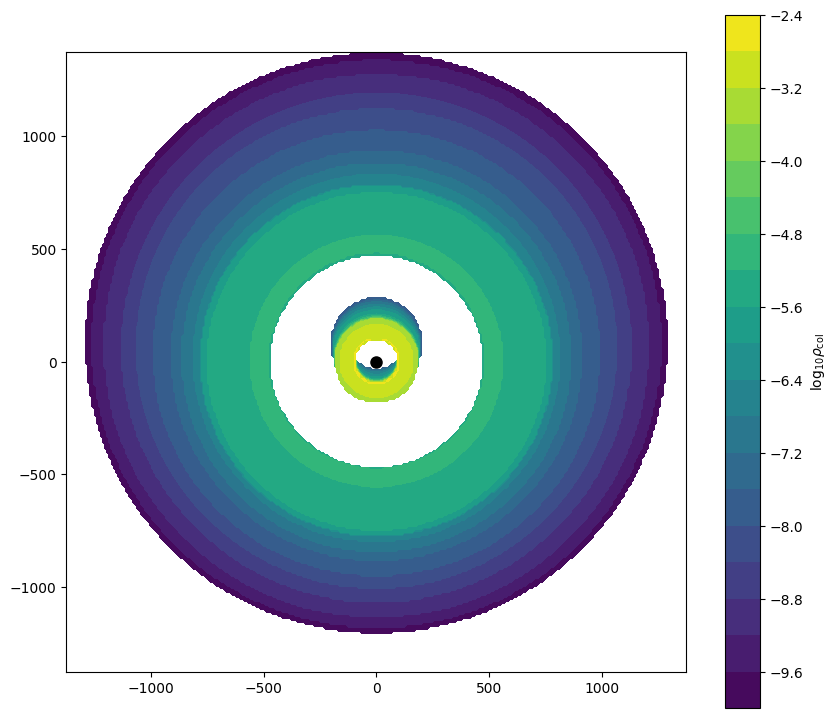

In [18]:
inc_ang = 5
projection = comp_BLR.project_blr_density_to_source_plane(inc_ang)
inc_ang *= np.pi / 180
x_vals = np.linspace(-comp_BLR.max_radius, comp_BLR.max_radius, np.size(projection, 0))
y_vals = np.linspace(-comp_BLR.max_radius, comp_BLR.max_radius, np.size(projection, 1))

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot([0], [0], "k.", markersize=16)
contours = ax.contourf(x_vals, y_vals, np.log10(projection), 20)
cbar = plt.colorbar(contours, ax=ax, label=r"log$_{10}\rho_{\rm{col}}$")
ax.set_aspect(1)
plt.show()

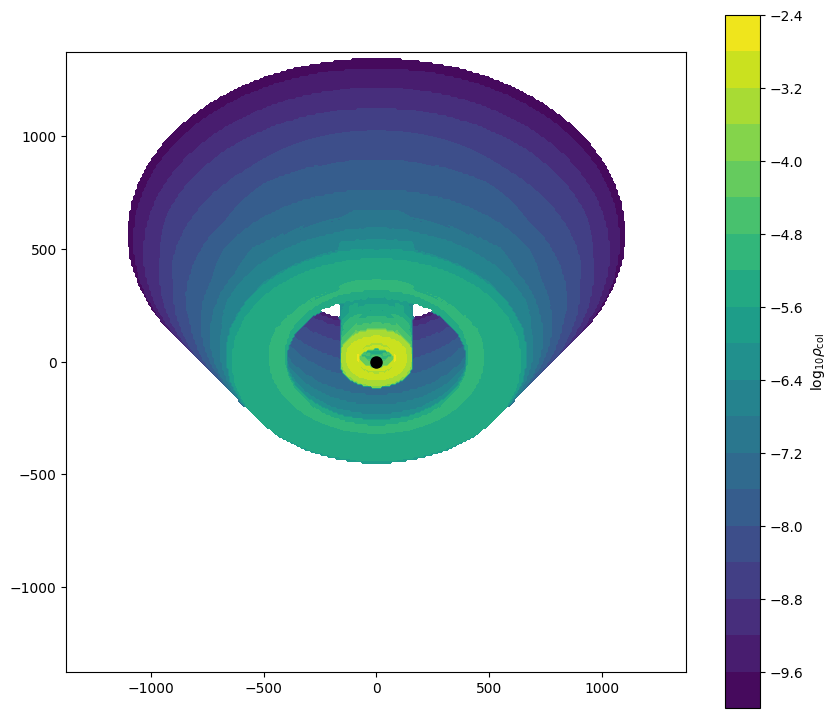

In [19]:
inc_ang = 45
projection = comp_BLR.project_blr_density_to_source_plane(inc_ang)
inc_ang *= np.pi / 180
x_vals = np.linspace(-comp_BLR.max_radius, comp_BLR.max_radius, np.size(projection, 0))
y_vals = np.linspace(-comp_BLR.max_radius, comp_BLR.max_radius, np.size(projection, 1))

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot([0], [0], "k.", markersize=16)
contours = ax.contourf(x_vals, y_vals, np.log10(projection), 20)
cbar = plt.colorbar(contours, ax=ax, label=r"log$_{10}\rho_{\rm{col}}$")
ax.set_aspect(1)
# fig.savefig("ComplexBLRColumnDensity.pdf")
plt.show()

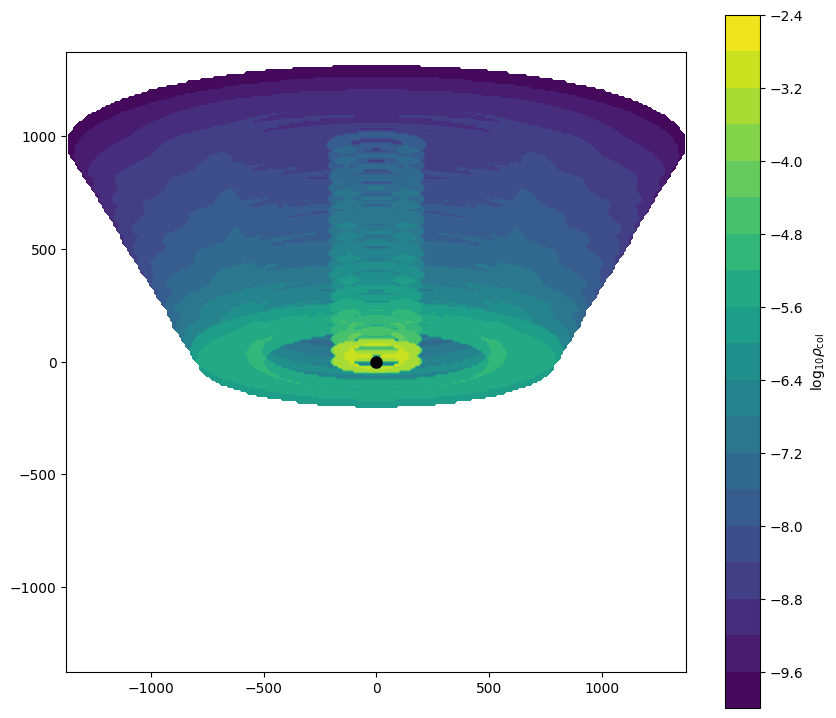

In [20]:
inc_ang = 75
projection = comp_BLR.project_blr_density_to_source_plane(inc_ang)
inc_ang *= np.pi / 180
x_vals = np.linspace(-comp_BLR.max_radius, comp_BLR.max_radius, np.size(projection, 0))
y_vals = np.linspace(-comp_BLR.max_radius, comp_BLR.max_radius, np.size(projection, 1))

fig, ax = plt.subplots(figsize=(10, 9))
ax.plot([0], [0], "k.", markersize=16)
contours = ax.contourf(x_vals, y_vals, np.log10(projection), 20)
cbar = plt.colorbar(contours, ax=ax, label=r"log$_{10}\rho_{\rm{col}}$")
ax.set_aspect(1)
plt.show()

In [21]:
inc_ang = 55
TF1_comp = comp_BLR.calculate_blr_scattering_transfer_function(inc_ang)

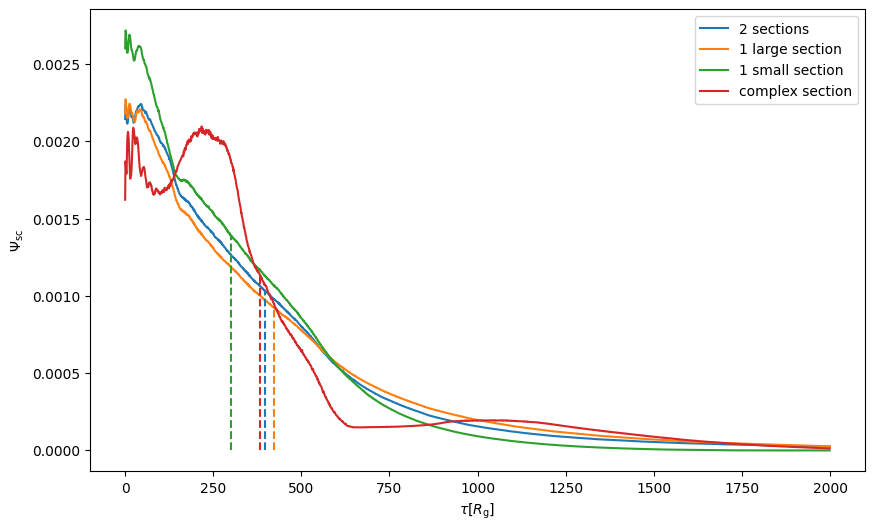

In [22]:
lim = 2000


tau_ax = np.linspace(0, len(TF1_comp), len(TF1_comp))
mean_complex_tf = np.sum(TF1_comp * tau_ax) / np.sum(TF1_comp)


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(scattering_tf_extra_section[:lim], label="2 sections")
ax.plot(scattering_TF_alt[:lim], label="1 large section")
ax.plot(scattering_tf[:lim], label="1 small section")
ax.plot(TF1_comp[:lim], label="complex section")

ax.set_prop_cycle(None)
ax.plot(
    [mean_extra_section, mean_extra_section],
    [0, scattering_tf_extra_section[int(mean_extra_section)]],
    "--",
)
ax.plot([mean_alt, mean_alt], [0, scattering_TF_alt[int(mean_alt)]], "--")
ax.plot([mean_original, mean_original], [0, scattering_tf[int(mean_original)]], "--")
ax.plot([mean_complex_tf, mean_complex_tf], [0, TF1_comp[int(mean_complex_tf)]], "--")


ax.set_xlabel(r"$\tau [R_{\rm{g}}]$")
ax.set_ylabel(r"$\Psi_{\rm{sc}}$")
ax.legend()

plt.show()

In [23]:
velocities = [-0.3, 0.1]
inc_ang = 55  # deg
scalefactor = 30

rescale_projection = rescale(
    comp_BLR.project_blr_density_to_source_plane(inc_ang), scalefactor
)
rescale_vel_slice = rescale(
    comp_BLR.project_blr_intensity_over_velocity_range(
        inc_ang, velocity_range=velocities
    ).flux_array,
    scalefactor,
)

x_vals = np.linspace(
    -comp_BLR.max_radius, comp_BLR.max_radius, np.size(rescale_projection, 0)
)
y_vals = np.linspace(
    -comp_BLR.max_radius, comp_BLR.max_radius, np.size(rescale_projection, 1)
)

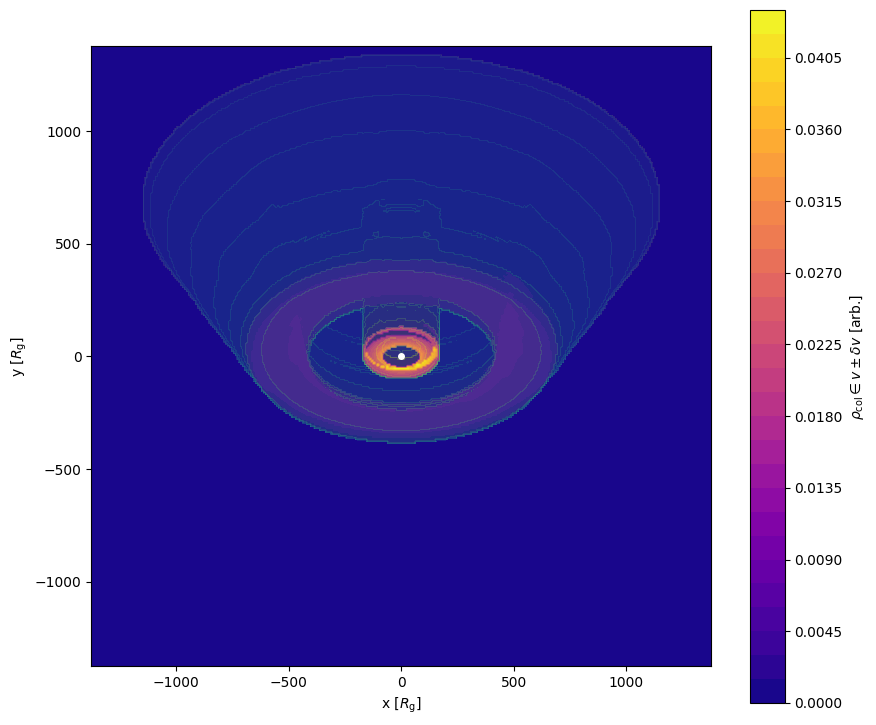

In [24]:
fig, ax = plt.subplots(figsize=(10, 9))
contours = ax.contourf(x_vals, y_vals, rescale_vel_slice, 40, cmap="plasma")
ax.contourf(x_vals, y_vals, np.log10(rescale_projection), 20, alpha=0.2)
cbar = plt.colorbar(
    contours, ax=ax, label=r"$\rho_{\rm{col}} \in v \pm \delta v$ [arb.]"
)
ax.plot([0], [0], "w.-", markersize=8)
ax.set_xlabel(r"x [$R_{\rm{g}}$]")
ax.set_ylabel(r"y [$R_{\rm{g}}$]")

ax.set_aspect(1)
# fig.savefig("ComplexBLRMedVelSlice.pdf")
plt.show()

In [25]:
total_time = time.time() - t_start
print("total time elapsed: " + str(round(total_time, 0)) + " s")

total time elapsed: 446.0 s
